In [64]:
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm
from scipy.optimize import fminbound
from skimage.filters import threshold_otsu

In [65]:
data = io.loadmat('./data-1.mat')
print(type(data), data.keys())


<class 'dict'> dict_keys(['__header__', '__version__', '__globals__', 'B', 'Ba', 'Omega', 'Y'])


In [66]:
B = data['B']
Ba = data['Ba']
Omega = data['Omega']
Y = data['Y'].reshape(-1)

print(B.shape, Ba.shape, Omega.shape, Y.shape)

(1000, 8) (1000, 40) (8, 8) (1000,)


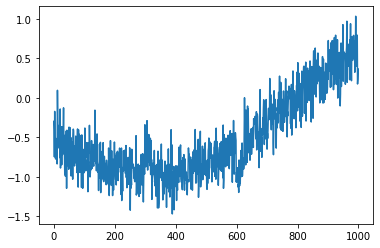

In [67]:
plt.plot(Y)

In [68]:
# helper functions from example code
def BSplineBasis(x: np.array, knots: np.array, degree: int) -> np.array:
    
    nKnots = knots.shape[0]
    lo = min(x[0], knots[0])
    hi = max(x[-1], knots[-1])
    
    augmented_knots = np.append(np.append([lo]*degree, knots), [hi]*degree)
    DOF = nKnots + degree + 1 # DOF = K+M, M = degree+1
    spline = BSpline(augmented_knots, np.eye(DOF), degree, extrapolate=False)
    B = spline(x)
    return B

def thresh(x, t, tau):
    assert t in ['s', 'h']

    if t is 't':
        tmp = x.copy()
        tmp[np.abs(tmp) < tau] = 0
        return tmp
    else:
        return np.sign(x)*np.maximum(np.abs(x)-tau, 0)

def splinegcv(lam, Y, C, Z, nmiss, W):
    # % Estimate Generalized Cross-validation value

    ndim = len(np.squeeze(Y).shape)
    H = []
    dfi = np.zeros(ndim)
    for idim in range(ndim):
        # print(ndim,idim)
        L1 = C[idim].shape[0]
        # o = np.ones(L1)+lam*np.diag(C[idim])
        o = 1+lam*np.diag(C[idim])
        tmp = Z[idim]@np.diag(1/o)@Z[idim].T
        H.append(tmp)

        dfi[idim] = sum(1/(1+lam*np.diag(C[idim])))

    df = np.product(dfi)
    if ndim == 1:
        Yhat = H[0]@Y
    elif ndim == 2:
        # print(H[0].shape,H[1].shape,Y.shape)
        Yhat = H[0]@Y@H[1]
    elif ndim >= 3:
        raise NotImplementedError
        # Yhat = double(ttm(tensor(Y),H));

    if not W:
        RSS = ((Y-Yhat)**2).sum()
    else:
        diff = Y-Yhat
        RSS = (diff*W*diff).sum()

    n = len(Y)
    GCVscore = RSS/(n-nmiss)/(1-df/n)**2
    return GCVscore

def bsplineSmoothDecompauto(y, B, Ba, lam, gamma, maxIter=20, errtol=1e-6):
    def plus0(x): return np.maximum(x, 0)
    def norm(x): return np.linalg.norm(x, 2)
    sizey = y.shape
    ndim = len(y.squeeze().shape)

    if ndim == 1:
        Lbs = 2*norm(Ba)**2
        X = np.zeros(Ba.shape[1])
        a = 1
        BetaA = X.copy()
    elif ndim == 2:
        Lbs = 2*norm(Ba[0])**2*norm(Ba[1])**2
        X = np.zeros((Ba[0].shape[1], Ba[1].shape[1]))
        BetaA = X.copy()

    if len(lam) == 1:
        lam = np.ones(ndim)*lam

    SChange = 1e10
    H = []
    a = np.zeros_like(y)
    C = []
    Z = []

    
    Li = sqrtm(B.T@B)
    Li = Li + 1e-8*np.eye(*Li.shape)
    Di = np.diff(np.eye(B.shape[1]), 1, axis=0)
    tmp = np.linalg.pinv(Li.T)@(Di.T@Di)@np.linalg.pinv(Li)
    Ui, ctmp, _ = np.linalg.svd(tmp)
    C.append(np.diag(ctmp))
    Z.append(B@np.linalg.pinv(Li.T)@Ui)

    iIter = 0
    t = 1

    while SChange > errtol and iIter < maxIter:
        iIter += 1
        Sold = a
        BetaSold = BetaA
        told = t
        def gcv(x): return splinegcv(x, y, C, Z, 0, [])

        if len(lam) == 0 and iIter == 1:
            lam = fminbound(gcv, 1e-2, 1e3)
            lam = lam*np.ones(ndim)

        # % %
        H = []
        for idim in range(ndim):
            L1 = C[idim].shape[0]
            o = np.ones(L1)+lam[idim]*np.diag(C[idim])
            tmp = Z[idim]@np.diag(1/o)@Z[idim].T
            H.append(tmp)
        if ndim == 1:
            yhat = H[0]@(y-a)
            BetaSe = X + 2/Lbs*Ba.T@(y - Ba@X - yhat)
        elif ndim == 2:
            yhat = H[0]@(y-a)@H[1]
            BetaSe = X + 2/Lbs*Ba.T@(y - Ba@X@Ba.T - yhat)@Ba

        maxYe = np.abs(BetaSe).max()

        # %
        if not gamma and iIter % 3 == 1:
            gamma = threshold_otsu(np.abs(BetaSe)/maxYe)*maxYe*Lbs

        # change 'h' to 's' for softthresholding
        BetaA = thresh(BetaSe, 'h', gamma/Lbs)
        if ndim == 1:
            a = Ba@BetaA
        elif ndim == 2:
            a = Ba @BetaA@ Ba.T
        t = (1+(1+4*told**2)**0.5)/2

        if iIter == 1:
            X = BetaA
        else:
            X = BetaA+(told-1)/t*(BetaA-BetaSold)

        SChange = a-Sold
        SChange = (SChange**2).sum()

    return yhat, a

In [69]:
yhat, a = bsplineSmoothDecompauto(Y, B, Ba, [], [])

e = Y - yhat - a

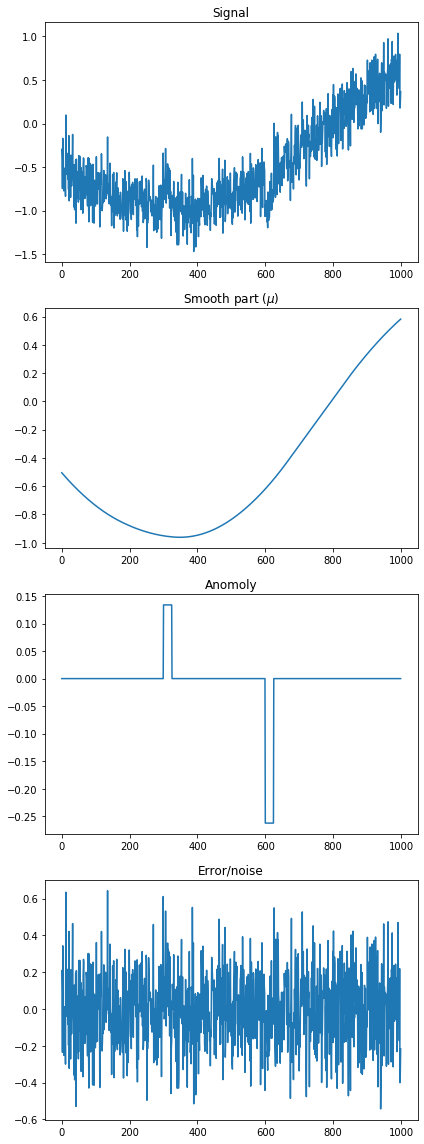

In [70]:
plt.figure(figsize=(6,16))
plt.subplot(4, 1, 1)
plt.title('Signal')
plt.plot(Y)

plt.subplot(4, 1, 2)
plt.title('Smooth part ($\mu$)')
plt.plot(yhat)

plt.subplot(4, 1, 3)
plt.title('Anomoly')
plt.plot(a)

plt.subplot(4, 1, 4)
plt.title('Error/noise')
plt.plot(e)

plt.tight_layout()